# Data Pre Processing #

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [11]:
df1 = pd.read_csv("PR_audacity_combined.csv")
df2 = pd.read_csv("PR_jabref_combined.csv")
df3 = pd.read_csv("PR_powertoys_combined.csv")

df1['repo'] = 1
df2['repo'] = 2
df3['repo'] = 3

#combine all the data
df = pd.concat([df1, df2, df3])

In [12]:
df.head()

,pr_number,created_at,merged_at,author,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,...,number_of_reviews_requested,number_of_revisions,number_of_milestones,dependency_changes,comment_authors,issue_comments_text,reviews_text,issue_text,review_comments,repo
0,7308,2024-09-10T13:07:38Z,2024-09-10T13:49:46Z,igorkorsukov,0,0,1,9,2,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
1,7303,2024-09-10T12:15:27Z,2024-09-10T12:42:48Z,igorkorsukov,0,0,1,9,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
2,7301,2024-09-10T10:27:20Z,2024-09-10T13:13:54Z,grliszas14,0,0,2,40,1,1,...,0,2,0,False,[],NaN,NaN,Resolves: https://github.com/audacity/audacity...,NaN,1
3,7288,2024-09-09T13:13:46Z,2024-09-09T14:53:04Z,LWinterberg,0,0,1,12,3,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1
4,7295,2024-09-10T08:53:37Z,2024-09-10T09:58:23Z,grliszas14,0,0,1,2,1,1,...,0,1,0,False,[],NaN,NaN,NaN,NaN,1


In [13]:
#if comment_author isnt empty list then set comments to 1 else 0
df['comments'] = df['comment_authors'].apply(lambda x: 0 if x.count("'")==0 else 1)

#if comment_author isnt empty then count the number of apostrophes and divide that by 2 to get the number of comments as an integer
#df['comment_author_number'] = df['comment_authors'].apply(lambda x: 0 if pd.isnull(x) else int(x.count("'")/2))
df['comment_author_number'] = df['comment_authors'].apply(lambda x: int(x.count("'") / 2))


#count words in issue text only 
df['issue_text_wordiness'] = df['issue_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 


In [14]:
#count words in issue comments text only if df[comments] ==1 else put 0
df['issue_comments_text_length'] = df['issue_comments_text'].apply(lambda x: 0 if pd.isnull(x) else len(x.split())) 

#now calcualte wordiness by dividing the number of words by the number of comments
df['issue_comments_text_wordiness'] = (df['issue_comments_text_length']//df['comment_author_number'])

#count the nubemr of times inf appears in issue_comments_tex_wordiness
count_inf = np.isinf(df['issue_comments_text_wordiness']).sum()
print(f"Number of times 'inf' appears: {count_inf}")

Number of times 'inf' appears: 816


In [16]:
# drop time_since_last_commit and test_coverage columns
df.drop(['time_since_last_commit', 'test_coverage','dependency_changes', 'number_of_linked_issues', 'number_of_milestones','number_of_revisions'], axis=1, inplace=True)

#divide review_duration and time to first reponse  by 3600 to get hours
#updated_at marks the last time the PR or issue was modified in any way 
# (whether through comments, code updates, status changes, or label changes).
df['review_duration'] = df['review_duration']/3600

#Time it took to receive the first feedback or comment on a PR after it was created.
df['time_to_first_response'] = df['time_to_first_response']/3600


In [17]:
#fill out the missing values with 0
df['time_to_first_response'] = df['time_to_first_response'].fillna(0)

#drop comment_authors column
df.drop(['comment_authors'], axis=1, inplace=True)


In [18]:
df['code_changes_ratio'] = df['lines_of_code_changed'] / df['number_of_files_changed']

#if code_changes_ratio is nan fill with 0
df['code_changes_ratio'] = df['code_changes_ratio'].fillna(0)


In [19]:
#list all teh unique lebales as well as acount for each
labels_all = df['labels'].unique()

#replace [ or ] with empty string from labels_all
labels_all = str(labels_all)
labels_all = labels_all.replace('[',',').replace(']',',')

#replace double speech marks with a comma 
labels_all = labels_all.replace('" "', '')

#remove all the speech marks
labels_all = labels_all.replace('"', '')

#remove the first comma
labels_all = labels_all[3:]

#remove apostrophes and new lines and spaces
labels_all = labels_all.replace("'", "").replace("\n", "").replace(" ", "")

#removve double commas
labels_all = labels_all.replace(',,', ",")

#now ceate a list of all the labels that are unique
labels_all = labels_all.split(',')

#remove any empty strings
labels_all = list(filter(None, labels_all))

#remove duplicates
labels_all = list(dict.fromkeys(labels_all))



In [20]:
#Count number of labels
df['labels_count'] = df['labels'].apply(lambda x: 0 if pd.isnull(x) else int(x.count("'")/2))

#create a column for each label and set it to 1 if the label is present in the labels column
for label in labels_all:
    df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
    
#drop the original labels column
df.drop(['labels'], axis=1, inplace=True)
    

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = df['labels'].apply(lambda x: 1 if label in str(x) else 0)
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/4029804119.py:6: PerformanceWarning: DataFrame is highly fragmented.  Thi

In [21]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 1),  # less than 1 hour - group 1
    (df['Issue_Lifetime(hours)'] >= 1) & (df['Issue_Lifetime(hours)'] < 24), # between 1 hour and 1 days - group 2
    (df['Issue_Lifetime(hours)'] >= 24) & (df['Issue_Lifetime(hours)'] < 168),  # between 1 day1 and a week - group 3
    (df['Issue_Lifetime(hours)'] >= 168) & (df['Issue_Lifetime(hours)'] < 5040),  # between  week and a month - group 4
    (df['Issue_Lifetime(hours)'] >= 5040)  # more than a month - group 5
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4, 5]
group_dict={
    1: 'Less than 1 hour',
    2: 'Between 1 hour and 1 day',
    3: 'Between 1 day and a week',
    4: 'Between a week and a month',
    5: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/1279693152.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/1279693152.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issue Lifetime'] = np.select(conditions, groups)


## Data Distribution ##

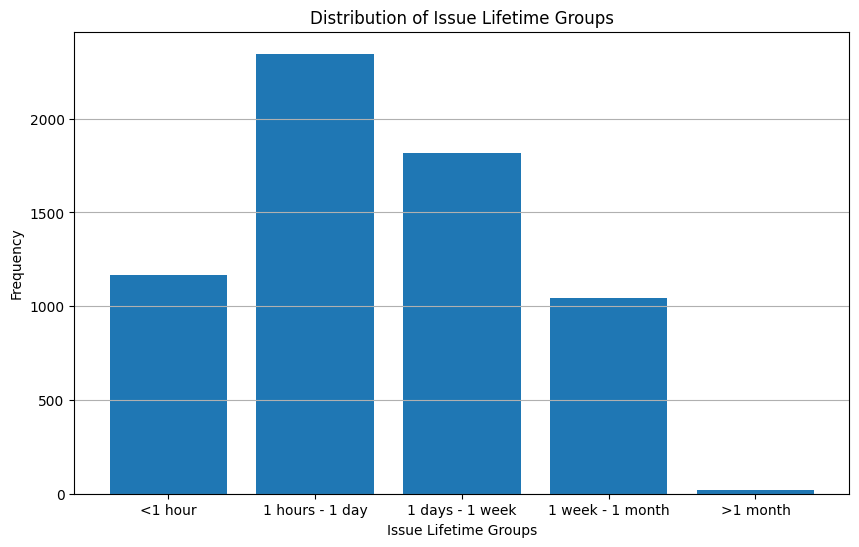

In [22]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<1 hour','1 hours - 1 day', '1 days - 1 week', '1 week - 1 month','>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

In [23]:
import pandas as pd

# Ensure 'created_at' and 'merged_at' are in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['merged_at'] = pd.to_datetime(df['merged_at'])

# Calculate 'Issues Opened in Last 2 Weeks' for each row
df['Issues Opened in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['created_at'] >= row['created_at'] - pd.Timedelta(days=14)) & 
                   (df['created_at'] < row['created_at'])].shape[0], axis=1
)

# Calculate 'Issues Closed in Last 2 Weeks' for each row
df['Issues Closed in Last 2 Weeks'] = df.apply(
    lambda row: df[(df['merged_at'] >= row['merged_at'] - pd.Timedelta(days=14)) & 
                   (df['merged_at'] < row['merged_at'])].shape[0], axis=1
)

# Calculate 'Open PRs at Open Date' for each row
df['Open PRs at Open Date'] = df.apply(
    lambda row: df[(df['created_at'] < row['created_at']) & 
                   (df['merged_at'] > row['created_at'])].shape[0], axis=1
)


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2401322557.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issues Opened in Last 2 Weeks'] = df.apply(
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2401322557.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Issues Closed in Last 2 Weeks'] = df.apply(
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2401322557.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [24]:
# Calculate the number of PRs opened by the author before each PR's created_at date
df['Author PRs Opened'] = df.apply(
    lambda row: df[(df['author'] == row['author']) & 
                   (df['created_at'] < row['created_at'])].shape[0], axis=1
)


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2155083328.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Author PRs Opened'] = df.apply(


In [25]:
#determien teh day ofthe week teh PR was created
df['day_of_week'] = df['created_at'].dt.dayofweek
#0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday

#for df['weekday'] set to 1 if day_of_week is between 0 and 4 else 0
df['weekday'] = df['day_of_week'].apply(lambda x: 1 if x >= 0 and x <= 4 else 0)

/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2111001302.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_week'] = df['created_at'].dt.dayofweek
/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/2111001302.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weekday'] = df['day_of_week'].apply(lambda x: 1 if x >= 0 and x <= 4 else 0)


In [26]:
#check if the PR was created between 4pm and 9pm
#this si the period in time that most people are working across the US
df['working_hours'] = df['created_at'].dt.hour.apply(lambda x: 1 if x >= 9 and x <= 21 else int(0))


/var/folders/8z/fy7_m7bd71552lpw8_st6mgr0000gn/T/ipykernel_39995/954217661.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['working_hours'] = df['created_at'].dt.hour.apply(lambda x: 1 if x >= 9 and x <= 21 else int(0))


In [27]:
#drop the created_at and merged_at columns and author
df.drop(['created_at', 'merged_at','author'], axis=1, inplace=True)

## Correlation Matrix ##

In [28]:
# Replace empty strings or invalid values with NaN
df.replace('', np.nan, inplace=True)

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
correlation_matrix


,pr_number,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,number_of_approvals,time_to_first_response,number_of_assignees,...,FancyZones-VirtualDesktop,Issue_Lifetime(hours),Issue Lifetime,Issues Opened in Last 2 Weeks,Issues Closed in Last 2 Weeks,Open PRs at Open Date,Author PRs Opened,day_of_week,weekday,working_hours
pr_number,1.000000,0.085121,-0.029055,0.040504,-0.006071,-0.005956,0.186987,0.209909,-0.033352,-0.118307,...,-0.002665,0.013631,0.101598,0.446190,0.456541,0.444433,0.017233,0.000764,0.009188,0.065269
number_of_comments,0.085121,1.000000,0.509252,0.422835,0.026330,0.039229,0.392896,0.126224,0.044650,0.066844,...,-0.003545,0.311362,0.402681,-0.030805,0.001142,0.037623,-0.093131,0.083574,-0.090599,0.011089
number_of_review_comments,-0.029055,0.509252,1.000000,0.412552,0.021394,0.043216,0.552855,0.070326,0.066857,0.086426,...,-0.002770,0.259764,0.400592,-0.092446,-0.055931,-0.014693,-0.113786,0.075266,-0.042361,0.003547
number_of_commits,0.040504,0.422835,0.412552,1.000000,0.058506,0.103424,0.301731,0.036673,0.041712,0.017141,...,-0.000742,0.214924,0.230005,-0.004112,0.020671,0.003353,-0.025864,0.074241,-0.052148,-0.018153
lines_of_code_changed,-0.006071,0.026330,0.021394,0.058506,1.000000,0.886776,0.033747,0.004300,0.001517,0.024322,...,-0.000534,0.007718,0.015384,-0.023397,-0.025356,0.015123,-0.013149,0.016781,-0.023245,0.007610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Open PRs at Open Date,0.444433,0.037623,-0.014693,0.003353,0.015123,0.020438,0.074363,0.117407,-0.008725,0.171864,...,-0.011129,0.007503,0.096281,0.576252,0.521809,1.000000,0.280637,-0.092701,0.039136,0.094595
Author PRs Opened,0.017233,-0.093131,-0.113786,-0.025864,-0.013149,0.002503,-0.125787,-0.033997,0.012256,0.266425,...,-0.007013,-0.052167,-0.175488,0.306936,0.288024,0.280637,1.000000,-0.111473,0.042482,0.116385
day_of_week,0.000764,0.083574,0.075266,0.074241,0.016781,0.027180,0.070825,-0.007012,0.006626,0.007894,...,-0.002070,0.050890,0.180654,-0.081420,-0.073901,-0.092701,-0.111473,1.000000,-0.672840,-0.017439
weekday,0.009188,-0.090599,-0.042361,-0.052148,-0.023245,-0.032274,-0.027728,0.045711,0.001493,0.016800,...,0.004901,-0.032690,-0.111676,0.024015,0.022646,0.039136,0.042482,-0.672840,1.000000,0.019720


# LLM

## Getting rid of predictors that have a weak correlation

In [29]:
# Get the correlations with 'review_duration'
review_duration_corr = correlation_matrix['Issue_Lifetime(hours)']

# Define a threshold for strong correlation (e.g., |correlation| > 0.2)
threshold = 0.20

# Filter the correlations that are above the threshold
strong_correlations = review_duration_corr[review_duration_corr.abs() > threshold].sort_values(ascending=False)

# Remove self-correlation
strong_correlations = strong_correlations.drop(labels=['Issue_Lifetime(hours)'])

# Display the strong correlations
print("Strong Correlations with 'Issue_Lifetime(hours)':\n", strong_correlations)

# Extract the columns that have strong correlations
strong_corr_columns = strong_correlations.index.tolist()

# Create a DataFrame with these columns
df_strong_corr = df[strong_corr_columns]


#df_strong_corr

Strong Correlations with 'Issue_Lifetime(hours)':
 time_to_first_response           0.451603
Issue Lifetime                   0.397943
number_of_comments               0.311362
review_duration                  0.308060
issue_comments_text_length       0.296314
number_of_review_comments        0.259764
comment_author_number            0.251786
issue_comments_text_wordiness    0.239670
number_of_commits                0.214924
Name: Issue_Lifetime(hours), dtype: float64


## split the data

In [30]:
# features is  dataframe without Issue Lifetime
features = df_strong_corr.drop('Issue Lifetime', axis=1)
target = df_strong_corr['Issue Lifetime']

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [32]:
import json

# Open the file in write mode
with open('LLM_tabular_data.jsonl', 'w', encoding='utf-8') as f:
    # Iterate over the rows in the DataFrame
    for index, row in df_train.iterrows():
        # Create the user message by formatting the prompt with the valuea frome each column for each row
        user_message = f"Classify, using ONLY 1 NUMBER between 1 and 5, the following GitHub issue, where 1 is 'Less than 1 hour', 2 is 'Between 1 hours and 1 day', 3 is 'Between 1 day and a week', and 4 is 'Between 1 week and 1 month' and 5 is 'More than a month', based on its features: - time_to_first_response: {row['time_to_first_response']}\n  - issue comments text length: {row['issue_comments_text_length']}\n - Review duration: {row['review_duration']}\n - number of Comments: {row['number_of_comments']}\n - Comment authors count : {row['comment_author_number']}\n- Issue comments text wordiness: {row['issue_comments_text_wordiness']}\n- Number of commits: {row['number_of_commits']}\n- Number of review comments: {row['number_of_commits']}\n"
        
        
        # Create the assistant message by taking the label
        assistant_message = str(row['Issue Lifetime'])
        
        # Construct the conversation object
        conversation_object = {
            "messages": [
                {"role": "system", "content": "GitHub Issue Lifetime Classifier"},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": assistant_message}
            ]
        }
        
        # Write the conversation object to one line in the file
        f.write(json.dumps(conversation_object, ensure_ascii=False) + '\n')

In [ ]:
# Invoking the API
from openai import OpenAI
client = OpenAI(api_key = 'open-api-key')


## Training from file

In [36]:
## Uplopading a training file
'''ft_file = client.files.create(
  file=open("LLM_tabular_data.jsonl", "rb"),
  purpose="fine-tune"
)
ft_file '''

'ft_file = client.files.create(\n  file=open("LLM_tabular_data.jsonl", "rb"),\n  purpose="fine-tune"\n)\nft_file '

In [37]:
## Creating a fine-tuned model
'''ft_job = client.fine_tuning.jobs.create(
  training_file=ft_file.id, 
  model="gpt-4o-mini-2024-07-18",
  suffix= "issueLifetime"
)
ft_job '''


'ft_job = client.fine_tuning.jobs.create(\n  training_file=ft_file.id, \n  model="gpt-4o-mini-2024-07-18",\n  suffix= "issueLifetime"\n)\nft_job '

In [38]:
# Check the status of the fine-tuning job
fine_tuning_job_id = 'ftjob-G3E1bamLNiBkgXUs3DwQxPZv'

job_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)

if job_status.status == 'succeeded':
    fine_tuned_model = job_status.fine_tuned_model
    print("Fine-tuned model ID:", fine_tuned_model)
elif job_status.status == 'failed':
    print("Fine-tuning job has failed.")
else:
    print("Fine-tuning job has not completed yet.") 

Fine-tuned model ID: ft:gpt-4o-mini-2024-07-18:northern-arizona-university-nau:issuelifetime:ANwYbVLz


In [39]:
df_strong_corr

,time_to_first_response,Issue Lifetime,number_of_comments,review_duration,issue_comments_text_length,number_of_review_comments,comment_author_number,issue_comments_text_wordiness,number_of_commits
0,0.000000,1,0,0.702222,0,0,0,NaN,1
1,0.000000,1,0,0.455833,0,0,0,NaN,1
2,0.000000,2,0,2.777222,0,0,0,NaN,2
3,0.000000,2,0,1.655833,0,0,0,NaN,1
4,0.000000,2,0,1.080556,0,0,0,NaN,1
...,...,...,...,...,...,...,...,...,...
2280,0.000000,2,0,4.739444,0,2,0,NaN,2
2281,0.446944,2,2,19.865556,374,1,2,187.0,3
2282,0.000000,3,0,29.755278,0,0,0,NaN,2
2283,0.000000,2,0,1.401667,0,0,0,NaN,1


# Utilising the fine tuned model

In [ ]:
import openai
import time
import pandas as pd
import concurrent.futures
import tiktoken
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report


openai.api_='open-api-key'

In [41]:
ft_job_id='ftjob-G3E1bamLNiBkgXUs3DwQxPZv'

In [42]:
tts_ft_model = client.fine_tuning.jobs.retrieve(ft_job_id).fine_tuned_model

In [43]:
# max_token here should be one since the class (1,2,3,4) is one token long. 
def query_chatgpt(prompt, model, temperature=0.0,  max_tokens=1, max_retries=5):
    """
    Function to query ChatGPT-4 with a given prompt, with retries for timeouts.

    :param prompt: Prompt string to send to ChatGPT-2.5
    :param model: The model to use, default is ChatGPT-3.5
    :param max_tokens: Maximum number of tokens to generate
    :param max_retries: Maximum number of retries for timeout
    :return: Response from ChatGPT-3.5 or None if all retries fail
    """
    attempt = 0
    max_content_tokens = 3999
    encoding = tiktoken.get_encoding("cl100k_base")
    encoding = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")

    # Function to truncate the message and avoid passing the limit of 4k tokens per gpt-3.5 fine-tuned model limitations
    def truncate_message(message, max_length):
        tokens = encoding.encode(message)
        if len(tokens) > max_length:
            truncated_tokens = tokens[:max_length]
            message = encoding.decode(truncated_tokens)
        return message

    # Truncate the prompt if necessary
    prompt = truncate_message(prompt, max_content_tokens)

    while attempt < max_retries:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(
                openai.chat.completions.create,
                model=model,
                messages=[{"role": "system", "content": "GitHub Issue Lifetime Classifier"}, {"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )
            try:
                response = future.result(timeout=5)  # 5 seconds timeout
                return response.choices[0].message.content
            except concurrent.futures.TimeoutError:
                print(f"Attempt {attempt + 1}/{max_retries} - Request timed out. Retrying...")
            except Exception as e:
                print(f"Attempt {attempt + 1}/{max_retries} - An error occurred: {e}")
            finally:
                attempt += 1

    print("Failed to get a response after several retries.")
    return None
    
labels =[ 1, 2, 3, 4, 5]

In [46]:
y_true = []
y_pred = []

iterations = len(df_test)
lifetime = df_test['Issue Lifetime']
predictors = df_test.drop('Issue Lifetime', axis=1)


# Now let's loop through the test data and classify the GitHub issues
for i, row in df_test.iterrows():
    correct_label = int(row['Issue Lifetime'])  # Access the correct label directly from the row
    description = row.drop('Issue Lifetime').to_string()  # Get the row data as a string
    #description = f"{test_data_facebook.iloc[i]['title']} \n {test_data_facebook.iloc[i]['body']}"
    print(f"Correct PR type: {correct_label}")
    
    prompt = f"Classify, using ONLY 1 NUMBER between 1 and 5, the following GitHub issue, where 1 is 'Less than 1 hour', 2 is 'Between 1 hours and 1 day', 3 is 'Between 1 day and a week', and 4 is 'Between 1 week and 1 month' and 5 is 'More than a month', based on its features: - time_to_first_response: {row['time_to_first_response']}\n  - issue comments text length: {row['issue_comments_text_length']}\n - Review duration: {row['review_duration']}\n - number of Comments: {row['number_of_comments']}\n - Comment authors count : {row['comment_author_number']}\n- Issue comments text wordiness: {row['issue_comments_text_wordiness']}\n- Number of commits: {row['number_of_commits']}\n- Number of review comments: {row['number_of_commits']}\n"

    response = query_chatgpt(prompt, tts_ft_model)
    
    if response is None:
        print("Failed to get a response after several retries. Skipping this item.")
        continue  # Skip this iteration and move to the next one
    
    # Clean the response to keep only letters (and optionally numbers)
    predicted_label = int(response)
    print(f"Predicted PR Lifetime: {predicted_label}")
    
    # Append to lists for evaluation
    y_true.append(correct_label)
    y_pred.append(predicted_label)
    time.sleep(3)  # Wait for 3 seconds before retrying

Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 1
Predicted PR Lifetime: 2
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 3
Predicted PR 

In [47]:
# Calculate weighted average F1-score, precision, and recall
f1 = f1_score(y_true, y_pred, labels=labels, average='weighted')
precision = precision_score(y_true, y_pred, labels=labels, average='weighted')
recall = recall_score(y_true, y_pred, labels=labels, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate TP, FP, FN, TN
results = {}
for i, label in enumerate(labels):
    results[label] = {'TP': cm[i, i]}
    results[label]['FP'] = cm[:, i].sum() - cm[i, i]
    results[label]['FN'] = cm[i, :].sum() - cm[i, i]
    results[label]['TN'] = cm.sum() - (results[label]['TP'] + results[label]['FP'] + results[label]['FN'])

# Print results_fb
for label, metrics in results.items():
    print(f"{label}: {metrics}")

# Save results_fb to CSV
results_df = pd.DataFrame(results).T
results_df['F1-score'] = f1
results_df['Recall'] = recall
results_df['Precision'] = precision

results_df.to_csv('confusion_matrix.csv')

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1-score = {f1}")

1: {'TP': np.int64(181), 'FP': np.int64(4), 'FN': np.int64(48), 'TN': np.int64(1047)}
2: {'TP': np.int64(410), 'FP': np.int64(58), 'FN': np.int64(68), 'TN': np.int64(744)}
3: {'TP': np.int64(306), 'FP': np.int64(67), 'FN': np.int64(62), 'TN': np.int64(845)}
4: {'TP': np.int64(177), 'FP': np.int64(75), 'FN': np.int64(26), 'TN': np.int64(1002)}
5: {'TP': np.int64(1), 'FP': np.int64(1), 'FN': np.int64(1), 'TN': np.int64(1277)}
Precision = 0.8502271789586426
Recall = 0.83984375
F1-score = 0.8417534665947969


In [48]:
#accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.83984375


In [ ]:
#measeure which feature importnace of the LLM model
# Get the feature importance from the fine-tuned model
feature_importance = client.fine_tuning.models.retrieve(fine_tuned_model).feature